In [1]:
%autosave 0 

Autosave disabled


# Vertical Sesimic Profiling inversion

We are going to focus our attention to a common approach when dealing with geophysical inverse problems, regularization and prior information. In this example we will invert synthetic data from a vertical seismic profiling survey. To do so, we will discretize the following equation:
\begin{align}
t(z) =  \int_{0}^{z} \frac{1}{v(z')}dz',
\end{align}
where $t(z)$ is the traveltime from the surface to the depth $z$ and $v(z')$ represents the propagation speed of the medium. To make the problem linear we will parameterize the problem using slowness instead of speed. The discrete version for a regular $z$ sampling of it can be written as follows:
\begin{align}
t_i =  \sum_{j=0}^{N_i} s_j \Delta z,
\end{align}
where $\Delta z$ represents the sampling interval in the $z$ direction, while $t_i$ and $s_j$ are the traveltime and slowness at $z_i=N_i \Delta z$ depth, respectively.
In this example we will assume that the true subsurface vertical speed is given by the following equation:
\begin{align}
v(z)=3000 + \sqrt{1000 z},
\end{align}
expressed in km/s.

In [2]:
#Adding library modules to PYTHONPATH
import sys
sys.path.append("../python")
import numpy as np
#Plotting library
from matplotlib import pyplot as plt
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
params = {
    'image.cmap': 'gray',
    'axes.grid': False,
    'savefig.dpi': 300,  # to adjust notebook inline plot size
    'axes.labelsize': 14, # fontsize for x and y labels (was 10)
    'axes.titlesize': 14,
    'font.size': 14, 
    'legend.fontsize': 12,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14
}
matplotlib.rcParams.update(params)
#Inversion library-related modules
import pyVector as Vec
import pyOperator as Op
from pyLinearSolver import LCGsolver as LCG
import pyProblem as Prblm
from pyStopper import BasicStopper as Stopper

WARNING! DATAPATH not found. The folder /tmp will be used to write binary files


In [3]:
#Definition of the modeling operator forward and its adjoint
class VSP_op(Op.Operator):
    """
       Vertical Sesimic Profiling operator      
    """
    
    def __init__(self,model,data,dz,desampling):
        """Operator constructor"""
        self.setDomainRange(model,data)
        self.dz = dz                           #Sampling in depth
        self.desampling = int(desampling)      #Desampling of the data points (should be 1 or greater)
        self.M = model.getNdArray().shape[0]   #Number of model points
        self.N = data.getNdArray().shape[0]    #Number of data points
        if((self.M-2) < (self.N-2)*self.desampling): 
            raise ValueError("ERROR! Too many data points! Change desampling or number of data points")
        return
    
    def forward(self,add,model,data):
        """
           Modeling operator from slowness to traveltime
           add     = [no default] - boolean; Flag to add modeled data to input vector
           model   = [no default] - vector class; slowness model vector
           data    = [no default] - vector class; traveltime data vector
        """
        self.checkDomainRange(model,data)
        if(not add): data.zero()     #data = 0
        modelNd = model.getNdArray() #Getting pointer to Numpy model array
        dataNd = data.getNdArray()   #Getting pointer to Numpy data array
        #First data point
        dataNd[0] += modelNd[0]*dz
        for idata in range(1,self.N-1):
            dataNd[idata] += np.sum(modelNd[:(idata)*self.desampling+1])*dz
        #Last data point
        dataNd[-1] += np.sum(modelNd[:])*dz
        return
    
    def adjoint(self,add,model,data):
        """
           Adjoint operator from traveltime to slowness
           add     = [no default] - boolean; Flag to add modeled data to input vector
           model   = [no default] - vector class; slowness model vector
           data    = [no default] - vector class; traveltime data vector
        """
        self.checkDomainRange(model,data)
        if(not add): model.zero()    #model = 0
        modelNd = model.getNdArray() #Getting pointer to Numpy model array
        dataNd = data.getNdArray()   #Getting pointer to Numpy data array
        #First data point
        modelNd[0] += dataNd[0]*dz
        for idata in range(1,self.N-1):
            modelNd[:(idata)*self.desampling+1] += dataNd[idata]*dz
        #Last data point
        modelNd[:] += dataNd[-1]*dz
        return

In [4]:
dz = 2.
zmax = 1000.0
z = np.linspace(0.0,zmax,int(zmax/dz)+1)
vel = 3000.0 + np.sqrt(1000.0*z)
slowness = 1.0/vel
model_true = Vec.vectorIC(slowness)
#Desampling of receivers
desampling = 10 #20 m sampling
ndata = int(zmax/(dz*desampling))+1
data_true = Vec.vectorIC((ndata,))
VSP_10 = VSP_op(model_true,data_true,dz,desampling)

In [5]:
#Generating observed data
VSP_10.forward(False,model_true,data_true)

In [6]:
VSP_10.dotTest(True)

Dot-product test of forward and adjoint operators
-------------------------------------------------
Applying forward operator add=False
 Runs in: 0.0003180503845214844 seconds
Applying adjoint operator add=False
 Runs in: 0.00018596649169921875 seconds
Dot products add=False: domain=1.041767e+01 range=1.041767e+01 
Absolute error: 1.243450e-14
Relative error: 1.193597e-15 

Applying forward operator add=True
 Runs in: 0.0003440380096435547 seconds
Applying adjoint operator add=True
 Runs in: 0.00018095970153808594 seconds
Dot products add=True: domain=2.083534e+01 range=2.083534e+01 
Absolute error: 3.197442e-14
Relative error: 1.534624e-15 

-------------------------------------------------


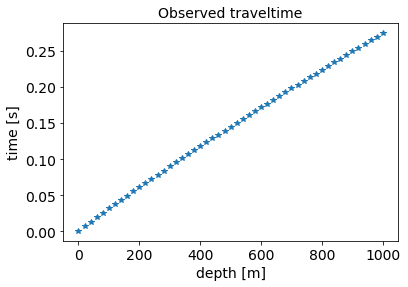

In [7]:
fig,ax=plt.subplots()
plt.plot(z[::desampling],data_true.getNdArray(),'*')
plt.xlabel("depth [m]")
plt.ylabel("time [s]")
_=plt.title("Observed traveltime")

In [8]:
#Create stopping criteria and related object
niter = 2000
Stop  = Stopper(niter=niter)
#Create LCG solver
LCGsolver = LCG(Stop)
LCGsolver.setDefaults(save_obj=True) #Saving objective function within the solver

In [9]:
#Inital slowness model
model = model_true.clone().zero() #m = 0
VSP_prob = Prblm.ProblemL2Linear(model.clone(),data_true,VSP_10)

In [10]:
LCGsolver.run(VSP_prob,verbose=True)

##########################################################################################
				LINEAR CONJUGATE GRADIENT  SOLVER
	Restart folder: /tmp/restart_2020-07-23T12-33-13.127558/
	Modeling Operator:		Operator
##########################################################################################

iter = 0000, obj = 6.82008e-01, resnorm = 1.17e+00, gradnorm = 2.37e+02, feval = 2
iter = 0001, obj = 5.39592e-03, resnorm = 1.04e-01, gradnorm = 6.45e+00, feval = 4
iter = 0002, obj = 6.22682e-04, resnorm = 3.53e-02, gradnorm = 1.27e+00, feval = 6
iter = 0003, obj = 1.08804e-04, resnorm = 1.48e-02, gradnorm = 3.33e-01, feval = 8
iter = 0004, obj = 2.81691e-05, resnorm = 7.51e-03, gradnorm = 1.27e-01, feval = 10
iter = 0005, obj = 9.57360e-06, resnorm = 4.38e-03, gradnorm = 5.82e-02, feval = 12
iter = 0006, obj = 3.47089e-06, resnorm = 2.63e-03, gradnorm = 2.81e-02, feval = 14
iter = 0007, obj = 1.36467e-06, resnorm = 1.65e-03, gradnorm = 1.54e-02, feval = 16
iter = 0008, obj = 5.69

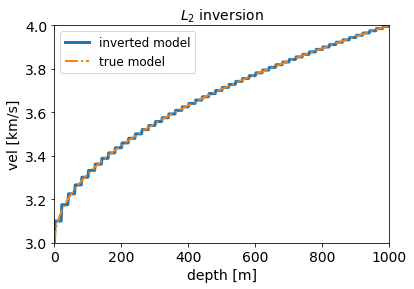

In [11]:
fig,ax=plt.subplots()
plt.plot(z,1.e-3/VSP_prob.model.getNdArray(),label='inverted model',linewidth=3)
plt.plot(z,1.e-3*vel,label='true model',linewidth=2,linestyle='-.')
plt.xlabel("depth [m]")
plt.ylabel("vel [km/s]")
ax.legend()
plt.ylim(3,4)
plt.xlim(0,1000)
_=plt.title("$L_2$ inversion")

By looking at the objective function value, we clearly see that we can perfectly match the observed traveltime values. In fact, the problem is underdetermined (i.e., we have more model parameters than observations). Because of this fact, we can only retrieve the average velocity between observation depths. Moreover, we will encounter issues when random noise is present in the recorded data.

In [12]:
#Let's add some noise to the recorded data
noisy_data = data_true.clone()
noisy_data_arr = noisy_data.getNdArray()
noisy_data_arr += np.random.normal(scale=np.mean(noisy_data_arr)*0.005, size=noisy_data_arr.shape)

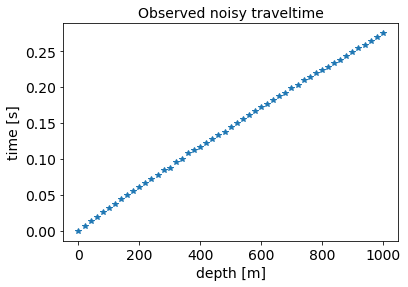

In [13]:
fig,ax=plt.subplots()
plt.plot(z[::desampling],noisy_data_arr,'*')
plt.xlabel("depth [m]")
plt.ylabel("time [s]")
_=plt.title("Observed noisy traveltime")

In [14]:
VSP_prob_noise = Prblm.ProblemL2Linear(model.clone(),noisy_data,VSP_10)
LCGsolver.run(VSP_prob_noise,verbose=True)

##########################################################################################
				LINEAR CONJUGATE GRADIENT  SOLVER
	Restart folder: /tmp/restart_2020-07-23T12-33-13.127558/
	Modeling Operator:		Operator
##########################################################################################

iter = 0000, obj = 6.80454e-01, resnorm = 1.17e+00, gradnorm = 2.37e+02, feval = 2
iter = 0001, obj = 5.42825e-03, resnorm = 1.04e-01, gradnorm = 6.47e+00, feval = 4
iter = 0002, obj = 6.40848e-04, resnorm = 3.58e-02, gradnorm = 1.25e+00, feval = 6
iter = 0003, obj = 1.33470e-04, resnorm = 1.63e-02, gradnorm = 3.48e-01, feval = 8
iter = 0004, obj = 4.01160e-05, resnorm = 8.96e-03, gradnorm = 1.43e-01, feval = 10
iter = 0005, obj = 1.69170e-05, resnorm = 5.82e-03, gradnorm = 6.93e-02, feval = 12
iter = 0006, obj = 8.30352e-06, resnorm = 4.08e-03, gradnorm = 3.52e-02, feval = 14
iter = 0007, obj = 4.76789e-06, resnorm = 3.09e-03, gradnorm = 2.21e-02, feval = 16
iter = 0008, obj = 2.82

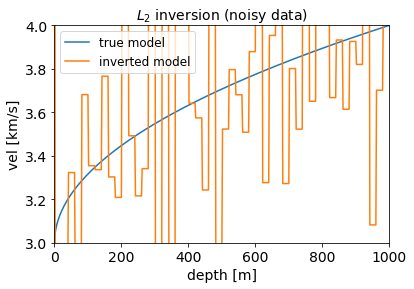

In [15]:
fig,ax=plt.subplots()
plt.plot(z,1.e-3*vel,label='true model')
plt.plot(z,1.e-3/VSP_prob_noise.model.getNdArray(),label='inverted model')
plt.xlabel("depth [m]")
plt.ylabel("vel [km/s]")
ax.legend()
plt.ylim(3,4)
plt.xlim(0,1000)
_=plt.title("$L_2$ inversion (noisy data)")

A simple method to avoid these issues is to add prior knowledge to the inversion. In fact, we can change to problem to be solved and add a regularization term. We will test two kind of regularization: one in which a smooth constraint is added and another one where a prior model is assumed and employed in the regularization term.

In the first case, the objective function to be minimized is the following:
\begin{align}
\phi_{smooth}(\mathbf{m})=\frac{1}{2}\|G \mathbf{m} - \mathbf{d}_{obs} \|_2^2 + \frac{\epsilon^2}{2} \|D_1 \mathbf{m}\|_2^2,
\end{align}
where $\mathbf{m}$ represents the slowness model, $\mathbf{d}_{obs}$ is the observed traveltimes, while $G$ and $D_1$ are the modeling and a first-order derivative operators, respectively. The variable $\epsilon$ is the trade-off weight and is going to be set on the basis of trial and error.

In [16]:
#Defining first-order derivative operator
class FirstDerivative(Op.Operator):
    def __init__(self, model, sampling=1.):
        """
        Compute 2nd-order first derivative
        :param model    : vector class; domain vector
        :param sampling : scalar; sampling step [1.]
        """
        self.sampling = sampling
        super(FirstDerivative, self).__init__(model, model)

    def forward(self, add, model, data):
        """Forward operator"""
        self.checkDomainRange(model, data)
        if not add:
            data.zero()
        # Getting Ndarrays
        x = model.getNdArray()
        y = data.getNdArray()
        #Computing the derivative
        y[:-1] += (x[1:] - x[:-1]) / self.sampling
        y[-1] += (x[-1] - x[-2]) / self.sampling #Boundary condition
        return

    def adjoint(self, add, model, data):
        """Adjoint operator"""
        self.checkDomainRange(model, data)
        if not add:
            model.zero()
        # Getting Ndarrays
        x = model.getNdArray()
        y = data.getNdArray()
        x[0] -= y[0] / self.sampling #Boundary condition
        x[1:-1] += (y[:-2] - y[1:-1]) / self.sampling
        x[-2] -= y[-1] / self.sampling
        x[-1] += (y[-2] + y[-1]) / self.sampling
        return

In [17]:
#Instantiating regularization operator
D1 = FirstDerivative(model_true,dz)
#Instantiating regularized problem with noise-free data
VSP_prob_regD1 = Prblm.ProblemL2LinearReg(model.clone(),data_true,VSP_10,epsilon=1.0,reg_op=D1)
#Estimating a value for the regularization weight epsilon
epsilon_balance = VSP_prob_regD1.estimate_epsilon(True)
VSP_prob_regD1.epsilon = epsilon_balance * 1e-4

Epsilon Scale evaluation
	Epsilon balancing the data-space gradients is: 4.25e+04


In [18]:
LCGsolver.run(VSP_prob_regD1,verbose=True)

##########################################################################################
				LINEAR CONJUGATE GRADIENT  SOLVER
	Restart folder: /tmp/restart_2020-07-23T12-33-13.127558/
	Modeling Operator:		 VStack 
##########################################################################################

iter = 0000, obj = 6.82008e-01, resnorm = 1.17e+00, gradnorm = 2.37e+02, feval = 2
iter = 0001, obj = 5.39593e-03, resnorm = 1.04e-01, gradnorm = 6.45e+00, feval = 4
iter = 0002, obj = 6.22693e-04, resnorm = 3.53e-02, gradnorm = 1.27e+00, feval = 6
iter = 0003, obj = 1.08819e-04, resnorm = 1.48e-02, gradnorm = 3.33e-01, feval = 8
iter = 0004, obj = 2.81852e-05, resnorm = 7.51e-03, gradnorm = 1.27e-01, feval = 10
iter = 0005, obj = 9.58737e-06, resnorm = 4.38e-03, gradnorm = 5.82e-02, feval = 12
iter = 0006, obj = 3.47967e-06, resnorm = 2.64e-03, gradnorm = 2.82e-02, feval = 14
iter = 0007, obj = 1.36739e-06, resnorm = 1.65e-03, gradnorm = 1.54e-02, feval = 16
iter = 0008, obj = 5.67

iter = 0162, obj = 8.41319e-11, resnorm = 1.30e-05, gradnorm = 2.74e-10, feval = 326
iter = 0163, obj = 8.41319e-11, resnorm = 1.30e-05, gradnorm = 4.47e-11, feval = 328
iter = 0164, obj = 8.41319e-11, resnorm = 1.30e-05, gradnorm = 7.38e-11, feval = 330
iter = 0165, obj = 8.41319e-11, resnorm = 1.30e-05, gradnorm = 3.11e-10, feval = 332
iter = 0166, obj = 8.41319e-11, resnorm = 1.30e-05, gradnorm = 1.27e-10, feval = 334
iter = 0167, obj = 8.41319e-11, resnorm = 1.30e-05, gradnorm = 5.04e-11, feval = 336
iter = 0168, obj = 8.41319e-11, resnorm = 1.30e-05, gradnorm = 3.40e-11, feval = 338
iter = 0169, obj = 8.41319e-11, resnorm = 1.30e-05, gradnorm = 3.29e-11, feval = 340
iter = 0170, obj = 8.41319e-11, resnorm = 1.30e-05, gradnorm = 3.66e-11, feval = 342
iter = 0171, obj = 8.41319e-11, resnorm = 1.30e-05, gradnorm = 3.09e-10, feval = 344
iter = 0172, obj = 8.41319e-11, resnorm = 1.30e-05, gradnorm = 1.45e-10, feval = 346
iter = 0173, obj = 8.41319e-11, resnorm = 1.30e-05, gradnorm = 2.

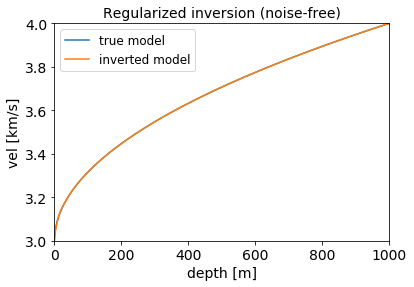

In [19]:
fig,ax=plt.subplots()
plt.plot(z,1.e-3*vel,label='true model')
plt.plot(z,1.e-3/VSP_prob_regD1.model.getNdArray(),label='inverted model')
plt.xlabel("depth [m]")
plt.ylabel("vel [km/s]")
ax.legend()
plt.ylim(3,4)
plt.xlim(0,1000)
_=plt.title("Regularized inversion (noise-free)")

In [20]:
#Instantiating regularized problem with noisy data
VSP_prob_regD1 = Prblm.ProblemL2LinearReg(model.clone(),noisy_data,VSP_10,epsilon=1.0,reg_op=D1)
#Estimating a value for the regularization weight epsilon
epsilon_balance = VSP_prob_regD1.estimate_epsilon(True)
VSP_prob_regD1.epsilon = epsilon_balance * 5e-2

Epsilon Scale evaluation
	Epsilon balancing the data-space gradients is: 4.25e+04


In [21]:
LCGsolver.run(VSP_prob_regD1,verbose=True)

##########################################################################################
				LINEAR CONJUGATE GRADIENT  SOLVER
	Restart folder: /tmp/restart_2020-07-23T12-33-13.127558/
	Modeling Operator:		 VStack 
##########################################################################################

iter = 0000, obj = 6.80454e-01, resnorm = 1.17e+00, gradnorm = 2.37e+02, feval = 2
iter = 0001, obj = 7.11160e-03, resnorm = 1.19e-01, gradnorm = 8.73e+01, feval = 4
iter = 0002, obj = 5.97796e-03, resnorm = 1.09e-01, gradnorm = 2.99e+01, feval = 6
iter = 0003, obj = 5.72799e-03, resnorm = 1.07e-01, gradnorm = 1.96e+01, feval = 8
iter = 0004, obj = 5.59148e-03, resnorm = 1.06e-01, gradnorm = 1.64e+01, feval = 10
iter = 0005, obj = 5.47851e-03, resnorm = 1.05e-01, gradnorm = 1.60e+01, feval = 12
iter = 0006, obj = 5.41146e-03, resnorm = 1.04e-01, gradnorm = 8.90e+00, feval = 14
iter = 0007, obj = 4.79111e-03, resnorm = 9.79e-02, gradnorm = 4.88e+01, feval = 16
iter = 0008, obj = 3.42

iter = 0154, obj = 1.66746e-05, resnorm = 5.77e-03, gradnorm = 1.07e-01, feval = 310
iter = 0155, obj = 1.66697e-05, resnorm = 5.77e-03, gradnorm = 1.02e-01, feval = 312
iter = 0156, obj = 1.66652e-05, resnorm = 5.77e-03, gradnorm = 9.89e-02, feval = 314
iter = 0157, obj = 1.66610e-05, resnorm = 5.77e-03, gradnorm = 9.66e-02, feval = 316
iter = 0158, obj = 1.66570e-05, resnorm = 5.77e-03, gradnorm = 9.37e-02, feval = 318
iter = 0159, obj = 1.66532e-05, resnorm = 5.77e-03, gradnorm = 9.15e-02, feval = 320
iter = 0160, obj = 1.66496e-05, resnorm = 5.77e-03, gradnorm = 8.96e-02, feval = 322
iter = 0161, obj = 1.66461e-05, resnorm = 5.77e-03, gradnorm = 8.61e-02, feval = 324
iter = 0162, obj = 1.66429e-05, resnorm = 5.77e-03, gradnorm = 8.43e-02, feval = 326
iter = 0163, obj = 1.66398e-05, resnorm = 5.77e-03, gradnorm = 8.37e-02, feval = 328
iter = 0164, obj = 1.66368e-05, resnorm = 5.77e-03, gradnorm = 8.08e-02, feval = 330
iter = 0165, obj = 1.66340e-05, resnorm = 5.77e-03, gradnorm = 7.

iter = 0328, obj = 1.65922e-05, resnorm = 5.76e-03, gradnorm = 2.50e-04, feval = 658
iter = 0329, obj = 1.65922e-05, resnorm = 5.76e-03, gradnorm = 2.42e-04, feval = 660
iter = 0330, obj = 1.65922e-05, resnorm = 5.76e-03, gradnorm = 2.31e-04, feval = 662
iter = 0331, obj = 1.65922e-05, resnorm = 5.76e-03, gradnorm = 2.24e-04, feval = 664
iter = 0332, obj = 1.65922e-05, resnorm = 5.76e-03, gradnorm = 2.16e-04, feval = 666
iter = 0333, obj = 1.65922e-05, resnorm = 5.76e-03, gradnorm = 2.08e-04, feval = 668
iter = 0334, obj = 1.65922e-05, resnorm = 5.76e-03, gradnorm = 2.05e-04, feval = 670
iter = 0335, obj = 1.65922e-05, resnorm = 5.76e-03, gradnorm = 1.98e-04, feval = 672
iter = 0336, obj = 1.65922e-05, resnorm = 5.76e-03, gradnorm = 1.89e-04, feval = 674
iter = 0337, obj = 1.65922e-05, resnorm = 5.76e-03, gradnorm = 1.82e-04, feval = 676
iter = 0338, obj = 1.65922e-05, resnorm = 5.76e-03, gradnorm = 1.72e-04, feval = 678
iter = 0339, obj = 1.65922e-05, resnorm = 5.76e-03, gradnorm = 1.

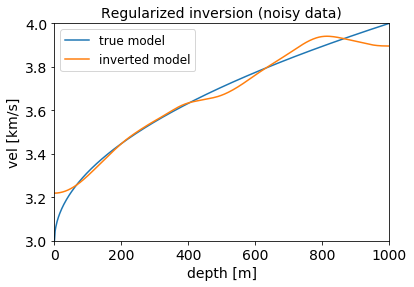

In [22]:
fig,ax=plt.subplots()
plt.plot(z,1.e-3*vel,label='true model')
plt.plot(z,1.e-3/VSP_prob_regD1.model.getNdArray(),label='inverted model')
plt.xlabel("depth [m]")
plt.ylabel("vel [km/s]")
ax.legend()
plt.ylim(3,4)
plt.xlim(0,1000)
_=plt.title("Regularized inversion (noisy data)")

In the second case (i.e., when a prior model is employed), the objective function to be minimized is written as follows:
\begin{align}
\phi_{smooth}(\mathbf{m})=\frac{1}{2}\|G \mathbf{m} - \mathbf{d}_{obs} \|_2^2 + \frac{\epsilon^2}{2} \|\mathbf{m} - \mathbf{m}_{prior}\|_2^2,
\end{align}
where $\mathbf{m}_{prior}$ is the prior model vector expressed as the following velocity profile:
\begin{align}
v_{prior}(z)  = 3100.+ 1.0 z
\end{align}

In [23]:
vel_prior = 3100.0 + z
model_prior = Vec.vectorIC(1.0/vel_prior)

In [24]:
#Instantiating regularized problem with prior model and noisy data
VSP_prob_prior = Prblm.ProblemL2LinearReg(model.clone(),noisy_data,VSP_10,epsilon=1.0,prior_model=model_prior)
#Estimating a value for the regularization weight epsilon
epsilon_balance = VSP_prob_prior.estimate_epsilon(True)
VSP_prob_prior.epsilon = epsilon_balance * 2.5e-1

Epsilon Scale evaluation
	Epsilon balancing the data-space gradients is: 2.04e+02


In [25]:
LCGsolver.run(VSP_prob_prior,verbose=True)

##########################################################################################
				LINEAR CONJUGATE GRADIENT  SOLVER
	Restart folder: /tmp/restart_2020-07-23T12-33-13.127558/
	Modeling Operator:		 VStack 
##########################################################################################

iter = 0000, obj = 7.31548e-01, resnorm = 1.21e+00, gradnorm = 2.52e+02, feval = 2
iter = 0001, obj = 9.88441e-03, resnorm = 1.41e-01, gradnorm = 1.06e+01, feval = 4
iter = 0002, obj = 9.76073e-04, resnorm = 4.42e-02, gradnorm = 2.66e+00, feval = 6
iter = 0003, obj = 8.65092e-05, resnorm = 1.32e-02, gradnorm = 4.99e-01, feval = 8
iter = 0004, obj = 5.05724e-05, resnorm = 1.01e-02, gradnorm = 5.47e-02, feval = 10
iter = 0005, obj = 5.01017e-05, resnorm = 1.00e-02, gradnorm = 4.51e-03, feval = 12
iter = 0006, obj = 5.00983e-05, resnorm = 1.00e-02, gradnorm = 2.77e-04, feval = 14
iter = 0007, obj = 5.00983e-05, resnorm = 1.00e-02, gradnorm = 1.24e-05, feval = 16
iter = 0008, obj = 5.00

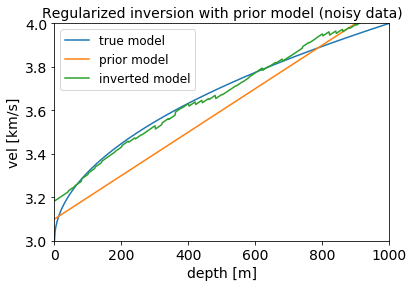

In [26]:
fig,ax=plt.subplots()
plt.plot(z,1.e-3*vel,label='true model')
plt.plot(z,1.e-3*vel_prior,label='prior model')
plt.plot(z,1.e-3/VSP_prob_prior.model.getNdArray(),label='inverted model')
plt.xlabel("depth [m]")
plt.ylabel("vel [km/s]")
ax.legend()
plt.ylim(3,4)
plt.xlim(0,1000)
_=plt.title("Regularized inversion with prior model (noisy data)")